# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
random.seed(42)

# Statistics

In [4]:
dataset_df = pd.read_csv("fehervali_lamp_night_webcam.csv", dtype={63: str}, header=None)
dataset_df = dataset_df[dataset_df[63].notna()]

In [5]:
dataset_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.282440,0.600049,-1.870000e-07,0.315119,0.568314,-0.020261,0.341418,0.497320,-0.028145,0.345182,...,0.245077,0.454705,-0.029709,0.256525,0.503494,-0.027200,0.265023,0.532601,-0.019086,a
1,0.306540,0.464684,-2.530000e-07,0.345548,0.433487,-0.015010,0.376949,0.352773,-0.019309,0.383595,...,0.273192,0.294298,-0.030596,0.283822,0.349954,-0.026084,0.290784,0.386303,-0.016583,a
2,0.312548,0.466279,-2.500000e-07,0.351508,0.435728,-0.017326,0.383225,0.355989,-0.022386,0.390655,...,0.279703,0.295002,-0.031225,0.289348,0.351177,-0.027367,0.296098,0.386388,-0.017859,a
3,0.312376,0.464121,-2.160000e-07,0.351002,0.428832,-0.016177,0.381091,0.352229,-0.021695,0.389459,...,0.280407,0.293631,-0.031949,0.289926,0.348591,-0.028363,0.296037,0.385675,-0.019074,a
4,0.318704,0.459572,-2.550000e-07,0.358304,0.432413,-0.016545,0.391470,0.354930,-0.021552,0.399716,...,0.289073,0.290601,-0.031273,0.297862,0.347676,-0.026504,0.302313,0.381447,-0.016831,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79117,0.750402,0.559602,-2.929276e-09,0.716881,0.523064,-0.005691,0.692819,0.458329,-0.010365,0.678697,...,0.795840,0.336924,-0.033126,0.804562,0.291845,-0.034732,0.811531,0.250759,-0.034977,9
79118,0.728110,0.584548,-2.703928e-09,0.692709,0.551154,-0.005868,0.666299,0.483619,-0.009379,0.652882,...,0.777827,0.349529,-0.027281,0.786762,0.306613,-0.029036,0.793311,0.268012,-0.030013,9
79119,0.692907,0.632380,-5.734563e-08,0.653591,0.594607,-0.005844,0.625896,0.525246,-0.009466,0.609404,...,0.732263,0.384610,-0.032487,0.739661,0.336064,-0.037982,0.745071,0.294783,-0.041747,9
79120,0.667865,0.630656,-2.710628e-08,0.628946,0.587478,-0.007682,0.601446,0.524650,-0.015188,0.580821,...,0.708207,0.390441,-0.035240,0.714427,0.343012,-0.038009,0.717539,0.295177,-0.039746,9


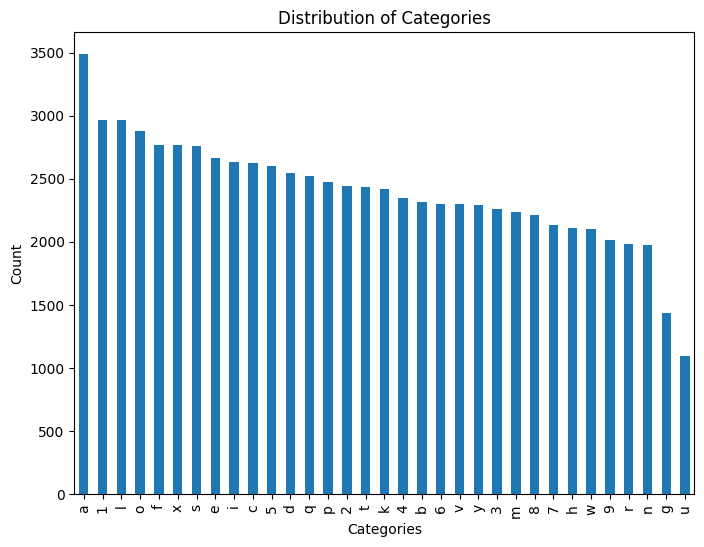

In [6]:
category_counts = dataset_df[63].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories')
plt.show()

In [14]:
path_to_data = "shuffled_dataset.csv"
shuffled_df = dataset_df.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv(path_to_data, index=False)

# Load dataset

In [15]:
sorted_cats = sorted(set(dataset_df[63].apply(lambda c: str(c))))
cat_to_num = {sign : i for i, sign in enumerate(sorted_cats)}
num_to_cat = {i : sign for sign, i in cat_to_num.items()}

tf_cat_to_num = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(cat_to_num.keys()),
        values=list(cat_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

In [98]:
def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def preprocess_lms(lm):
    mean = tf_nan_mean(lm)
    std = tf_nan_std(lm)
    lm = (lm - mean)/std
    lm = tf.where(tf.math.is_nan(lm),tf.constant(0.,lm.dtype),lm)
    return lm

def preprocess_cat(cat):
    return tf_cat_to_num.lookup(cat)

def preprocess_csv(line):
    columns = tf.strings.split(line, ',')
    features = tf.strings.to_number(columns[:-1], out_type=tf.float32)
    return preprocess_lms(features), preprocess_cat(columns[-1])

In [99]:
def get_dataset(csv_path, batch_size=None, drop_remainder=False, shuffle_size=None, repeat=False, cache=False):
    ds = tf.data.TextLineDataset(csv_path).skip(1) # skip header
    ds = ds.map(preprocess_csv, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    if batch_size:
        ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    if cache:
        ds = ds.cache()
    
    return ds

dataset = get_dataset(path_to_data, batch_size=256, shuffle_size=256*4)
total_size = len(dataset_df)

train_percentage = 0.8
train_size = int(total_size * train_percentage)

train_ds = dataset.take(train_size)
valid_ds = dataset.skip(train_size)

In [100]:
for batch in train_ds:
    print(batch)
    break

(<tf.Tensor: shape=(256, 63), dtype=float32, numpy=
array([[-0.34667847,  1.8107518 , -0.8532572 , ..., -0.3823077 ,
         1.7037492 , -0.9743593 ],
       [ 1.0350505 ,  1.58365   , -1.083502  , ...,  0.93041044,
         1.0643384 , -1.3516974 ],
       [ 0.11136929,  1.9244894 , -1.1708103 , ..., -0.0208113 ,
         0.1576841 , -1.2659243 ],
       ...,
       [ 0.16737656,  1.8183628 , -1.1162885 , ..., -0.16970924,
         0.797448  , -1.2827055 ],
       [ 1.2884376 ,  0.6064741 , -1.0045834 , ...,  1.4979426 ,
        -0.3877018 , -1.1271831 ],
       [ 0.4349625 ,  1.544629  , -1.2067261 , ...,  0.29197034,
         1.2881923 , -1.2982056 ]], dtype=float32)>, <tf.Tensor: shape=(256,), dtype=int32, numpy=
array([18, 28, 32, 29, 23, 30, 30, 11, 10,  6, 21, 10,  2, 32,  7, 31, 21,
       17, 25, 17, 27, 24, 21, 11, 11, 20, 10, 19, 14, 19, 24, 17, 11, 12,
        7, 23, 15, 14,  9, 30, 30, 27, 24,  7, 29, 16, 29, 13,  7, 18, 14,
        0,  8, 29, 17, 11,  1, 30, 12, 26, 10, 

# Model

In [101]:
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(sorted_cats), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8192      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 33)                2145      
                                                                 
Total params: 18593 (72.63 KB)
Trainable params: 18593 (72.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
%%time
model.fit(dataset,
          validation_data=valid_ds,
          epochs=30,
          verbose = 2)

Epoch 1/30
309/309 - 6s - loss: 2.1913 - accuracy: 0.3333 - 6s/epoch - 19ms/step
Epoch 2/30
309/309 - 3s - loss: 0.8940 - accuracy: 0.6928 - 3s/epoch - 8ms/step
Epoch 3/30
309/309 - 3s - loss: 0.6071 - accuracy: 0.8018 - 3s/epoch - 8ms/step
Epoch 4/30
309/309 - 3s - loss: 0.4784 - accuracy: 0.8514 - 3s/epoch - 8ms/step
Epoch 5/30
309/309 - 3s - loss: 0.3985 - accuracy: 0.8800 - 3s/epoch - 9ms/step
Epoch 6/30
309/309 - 3s - loss: 0.3515 - accuracy: 0.8956 - 3s/epoch - 8ms/step
Epoch 7/30
309/309 - 3s - loss: 0.3111 - accuracy: 0.9069 - 3s/epoch - 8ms/step
Epoch 8/30
309/309 - 3s - loss: 0.2861 - accuracy: 0.9148 - 3s/epoch - 8ms/step
Epoch 9/30
309/309 - 3s - loss: 0.2623 - accuracy: 0.9229 - 3s/epoch - 8ms/step
Epoch 10/30
309/309 - 3s - loss: 0.2496 - accuracy: 0.9260 - 3s/epoch - 8ms/step
Epoch 11/30
309/309 - 3s - loss: 0.2355 - accuracy: 0.9315 - 3s/epoch - 8ms/step
Epoch 12/30
309/309 - 3s - loss: 0.2241 - accuracy: 0.9340 - 3s/epoch - 8ms/step
Epoch 13/30
309/309 - 3s - loss: 0.2

# Testing

In [121]:
WEBCAM = 0

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def video_loop(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_hands.Hands(model_complexity=1,max_num_hands=1,min_detection_confidence=0.5,min_tracking_confidence=0.5) as hands:
            while True:
                _, image = video.read()
    
                if image is None:
                    break

                image. flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = hands.process(image)

                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                image = cv2.flip(image, 1)
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks: # 1 hand only
                        # Draw landmarks
                        mp_drawing.draw_landmarks(
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
        
                        # Get bounding box for the hand
                        lms = hand_landmarks.landmark
                        x_coords = [lm.x for lm in lms]
                        y_coords = [lm.y for lm in lms]
                        min_x, max_x = int(min(x_coords) * image.shape[1]), int(max(x_coords) * image.shape[1])
                        min_y, max_y = int(min(y_coords) * image.shape[0]), int(max(y_coords) * image.shape[0])

                        image = cv2.flip(image, 1)
                        # Draw the bounding box around the hand
                        cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)  # RGB green
                
                        # Get prediction and probability from function
                        data = []
                        for lm in lms:
                            data.extend([lm.x, lm.y, lm.z])
                            
                        pred, prob = process_data_func(data)

                        image = cv2.flip(image, 1)
                        # Display prediction and probability near the bounding box
                        label = f"{pred}: {prob:.2f}%"
                        cv2.putText(image, label, (min_x, min_y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2, cv2.LINE_AA)
    
                
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

In [122]:
def process_data(data):
    x = preprocess_lms(data)
    probs = model(np.array([x]))
    prob = np.max(probs, axis=1)[0]
    pred = np.argmax(probs)
    pred = num_to_cat[pred]
    return pred, prob

In [125]:
video_loop(WEBCAM, process_data)

None